# Load the Dataset

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.constraints import maxnorm
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D, Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
# import helper module
from helper import plot_images, plot_model, visualize_errors, predict_classes

# helper module to download the cifar 10 dataset
import cifar10
#print tensorflow version
print("Tensorflow Version: {}".format(tf.__version__))

Tensorflow Version: 1.4.0-dev20170920


In [3]:
#Set the path, where the dataset will be stored
cifar10.data_path = "/home/soeren/Documents/Github/CIFAR-10/data"
#change the style of matplotlib plots
matplotlib.style.use('ggplot')
# set train to 1 if you want to train a new model or 0 if you just want to load an already existing set of weights
train = 1

In [4]:
#Download and extract the data automatically, if it has not already been downloaded
cifar10.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [5]:
class_names = cifar10.load_class_names()
class_names

Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/batches.meta


[u'airplane',
 u'automobile',
 u'bird',
 u'cat',
 u'deer',
 u'dog',
 u'frog',
 u'horse',
 u'ship',
 u'truck']

In [6]:
#Load the training-set.
images_train, cls_train, labels_train = cifar10.load_training_data()

Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_1
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_2
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_3
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_4
Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/data_batch_5


In [7]:
images_test, cls_test, labels_test = cifar10.load_test_data()
print("Size of:")
print("-  Trainning-set:\t{}".format(len(images_train)))
print("-  Test-set:\t\t{}".format(len(images_test)))

Loading data: /home/soeren/Documents/Github/CIFAR-10/data/cifar-10-batches-py/test_batch
Size of:
-  Trainning-set:	50000
-  Test-set:		10000


## Plot some images

First we have to import the data dimensions. They have already been defined in the cifar 10 module 

In [8]:
from cifar10 import img_size, num_channels, num_classes

Image size is originally 32x32 but we will corp them to 24x24

In [9]:
img_size_cropped = 24

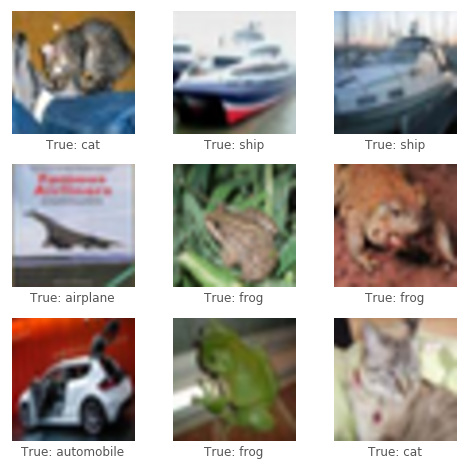

In [10]:
# Get the first images from test-set
images = images_test[0:9]

# Get the true classes from those images.
cls_true = cls_test[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images, cls_true,class_names)

## Apply data Augmentation

In [11]:
datagen = ImageDataGenerator(rotation_range=10, 
                             width_shift_range=0.2, 
                             height_shift_range=0.2, 
                             horizontal_flip=True, 
                             zoom_range=0.4)

datagen.fit(images_train)

# Create the CNN 

## Define hyper paramters

In [12]:
# Hight and Width of one image
IMAGE_SIZE = 32
# 3 channels, RED, GREEN and BLUE
CHANNELS = 3
# Number of Epochs (one Epoch represents all images)
NUM_EPOCH = 350
# Learning Rate (used for adjusting the weights)
LEARNING_RATE=1.0e-4

In [13]:
def pure_cnn_model():
    model = Sequential()
    
    model.add(Conv2D(96, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE,IMAGE_SIZE,CHANNELS)))
    model.add(Dropout(0.2))
              
    model.add(Conv2D(96, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(96, (3, 3), activation='relu', padding='same', strides = 2))
    model.add(Dropout(0.5))

    model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(192, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(192, (3, 3), activation='relu', padding='same', strides = 2))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(192, (3,3),padding = 'same'))
    model.add(Activation('relu'))
    model.add(Conv2D(192, (1,1),padding='valid'))
    model.add(Activation('relu'))
    model.add(Conv2D(10, (1,1),padding='valid'))
              
    model.add(GlobalAveragePooling2D())
    
    model.add(Activation('softmax'))
    
    model.summary()
    
    return model

In [14]:
model = pure_cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 96)        2688      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 96)        83040     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 96)        83040     
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 192)       166080    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 192)       331968    
__________

#  Define Training

## Save the model

In [15]:
augmented_checkpoint = ModelCheckpoint('save/cifar_10_pure_model.h5', # model filename
                            monitor='val_loss',   # quantity to monitor
                            verbose=0,            # verbosity - 0 or 1
                            save_best_only=True,  # The latest best model will not be overwritten
                            mode='auto')         # The decision to overwrite model is made
                                                  # automatically depending on the quantity to monitor

## Define the optimization

In [16]:
model.compile(loss='categorical_crossentropy',        # Better loss function for neural networks
              optimizer=Adam(lr=LEARNING_RATE),       # Adam optimizer with 1.0e-4 learning rate
              metrics = ['accuracy'])                 # Metrics to be evaluated by the model

## Start Training

In [17]:
model.load_weights("save/cifar_10_pure_model.h5")

In [18]:
if train:
    augmented_model_details = model.fit_generator(datagen.flow(images_train, labels_train, batch_size = 32), 
                             steps_per_epoch = len(images_train) / 32,
                            epochs = NUM_EPOCH,
                             validation_data = (images_test, labels_test),
                             callbacks=[augmented_checkpoint],
                             verbose=1)
    train = 1

Epoch 1/350
1562/1562 [==============================] - 500s 320ms/step - loss: 1.3629 - acc: 0.5108 - val_loss: 1.1921 - val_acc: 0.5748
Epoch 2/350
1562/1562 [==============================] - 441s 282ms/step - loss: 1.3279 - acc: 0.5223 - val_loss: 1.1336 - val_acc: 0.5973
Epoch 3/350
1562/1562 [==============================] - 431s 276ms/step - loss: 1.2952 - acc: 0.5361 - val_loss: 1.0800 - val_acc: 0.6114
Epoch 4/350
1562/1562 [==============================] - 450s 288ms/step - loss: 1.2681 - acc: 0.5451 - val_loss: 1.0645 - val_acc: 0.6114
Epoch 5/350
1562/1562 [==============================] - 424s 272ms/step - loss: 1.2383 - acc: 0.5565 - val_loss: 1.0516 - val_acc: 0.6235
Epoch 6/350
1562/1562 [==============================] - 425s 272ms/step - loss: 1.2128 - acc: 0.5703 - val_loss: 1.0589 - val_acc: 0.6166
Epoch 7/350
1562/1562 [==============================] - 423s 271ms/step - loss: 1.1889 - acc: 0.5786 - val_loss: 0.9744 - val_acc: 0.6566
Epoch 8/350
1562/1562 [====

KeyboardInterrupt: 

# Evaluate the model

## Load already trained model

In [ ]:
if train == 0:
    model.load_weights("save/cifar_10_model.h5")

In [ ]:
scores = model.evaluate(images_test,labels_test,verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
if train:
    # only works if training is applied
    plot_model(augmented_model_details)

# Show misclassified results

In [ ]:
class_pred = model.predict(images_test, batch_size=32)
print(class_pred[0])

In [ ]:
labels_pred = np.argmax(class_pred,axis = 1)
print(labels_pred)

In [ ]:
correct = (labels_pred == cls_test)
print(correct)
print("Nr. of correct predictions: {}".format(sum(correct)))

In [ ]:
incorrect = (correct == False)

images_error = images_test[incorrect]
labels_error = labels_pred[incorrect]
labels_true = cls_test[incorrect]
print(labels_error)
print(labels_true)

In [ ]:
plot_images(images_error[0:9], labels_true[0:9],class_names,labels_error[0:9])